In [1]:
import torch
import mlflow
from components.dataset import *
from components.mymodel import *

import pandas as pd
from typing import Tuple
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


mlflow.set_tracking_uri("https://web-mlflow.akraradets.duckdns.org")
mlflow.set_experiment(experiment_name='Soil')

<Experiment: artifact_location='mlflow-artifacts:/434256962446111249', creation_time=1688312103395, experiment_id='434256962446111249', last_update_time=1688312103395, lifecycle_stage='active', name='Soil', tags={}>

In [12]:
model_name:Models = Models.alexnet
image_set:Imageset = Imageset.p
device:Devices = Devices.all
environment:Environments = Environments.indoor
WORKERS = int(os.environ['WORKERS'])

def load_model(model_name:Models, image_set:Imageset, environment:Environments) -> Tuple[torch.nn.Module, pd.DataFrame]:
    search_name = f"{model_name.value}-{environment.value}"
    run_info = mlflow.search_runs(experiment_names=['Soil'],
                            filter_string=f"tags.mlflow.runName = '{search_name}'",)
    run_info = run_info.loc[run_info['params.Imageset'] == f'{image_set.value}']
    artifact_uri = run_info['artifact_uri'].iloc[0]
    loaded_model = mlflow.pytorch.load_model(f'{artifact_uri}/model')
    return loaded_model, run_info


In [13]:
model, run_info = load_model(model_name=model_name, image_set=image_set, environment=environment)

In [14]:
run_info

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_mse,metrics.train_mse,params.batch_size,params.Device,...,params.normalize_target,params.model_name,params.Imageset,params.Environment,tags.mlflow.source.type,tags.mlflow.log-model.history,tags.mlflow.user,tags.mlflow.source.name,tags.mlflow.parentRunId,tags.mlflow.runName
0,494fe5fc79044afd98c1824dcdefcab8,434256962446111249,FINISHED,mlflow-artifacts:/434256962446111249/494fe5fc7...,2023-09-06 09:42:29.483000+00:00,2023-09-06 10:18:40.167000+00:00,0.040857,0.132883,200,*,...,True,alexnet,P,Indoor,LOCAL,"[{""run_id"": ""494fe5fc79044afd98c1824dcdefcab8""...",Lianli,train_bigset.py,7fa314b073794b278af4d2dbab6c850e,alexnet-Indoor


In [4]:
run_id = run_info.iloc[0].loc['run_id']
mlflow.start_run(run_id=run_id)

<ActiveRun: >

In [5]:
from tqdm.notebook import tqdm
import numpy as np

model.to('cpu')
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(350),
    transforms.CenterCrop(224),
    # transforms.RandomCrop(224),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = SoilDataset_bigset(imageset=image_set, 
                            device=device, 
                            environment=environment, 
                            preprocessing=Preprocessing.training,
                            clip_target=True,
                            normalize_target=True)
dataset.preprocessing = Preprocessing.inferencing.value

Found 7103 images in ./dataset/bigset/P/*/*.


In [6]:
loader  = DataLoader(dataset=dataset,  batch_size=30, shuffle=False, num_workers=WORKERS)

In [7]:
model.eval()
DEVICE = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model.to(DEVICE)
ys = []
yhats = []
pic_names = []
with torch.no_grad():
    for X,y,pic_name in tqdm(loader):
        X = X.to(DEVICE)
        yhat = model(X) #1. model
        yhat = yhat.detach().cpu().numpy()
        y = y.detach().cpu().numpy()

        pic_names.append(list(pic_name))
        ys.append(y.reshape(-1))
        yhats.append(yhat.reshape(-1))

  0%|          | 0/237 [00:00<?, ?it/s]

In [8]:
df = pd.DataFrame([np.hstack(ys) * dataset.max_value, np.hstack(yhats) * dataset.max_value, np.hstack(pic_names)]).T
df.rename(columns = {
    0:'Target',
    1:'Predict',
    2:'Image name'
}, inplace=True)
df.set_index('Image name', inplace=True)
artifact_name:str = os.path.join('artifact','inference.csv')
df.to_csv(artifact_name)
mlflow.log_artifact(artifact_name)

In [9]:
df = df.sort_values(by=['Target'])

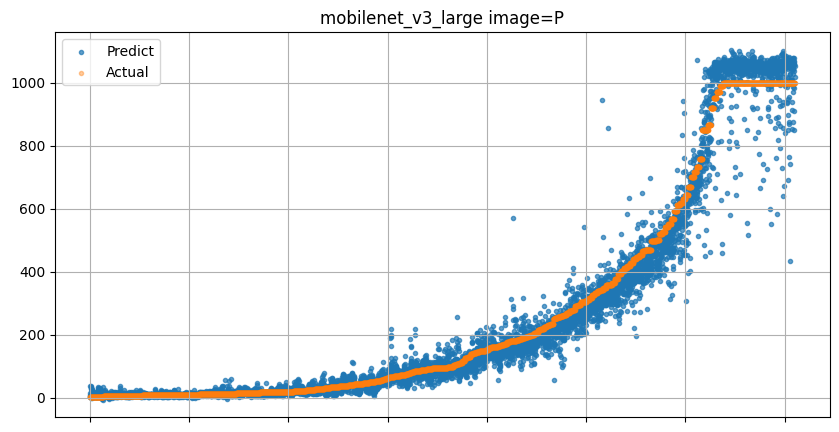

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(range(len(df)), df['Predict'], marker='.', alpha=0.7, label='Predict')
ax.scatter(range(len(df)), df['Target'], marker='.', alpha=0.4, label='Actual')
ax.grid()
ax.legend()
ax.set_xticklabels([])
ax.set_title(f"{model_name.value} image={image_set.value}")
plt.show()

In [11]:
mlflow.log_figure(fig, 'inference.png')

In [12]:
mlflow.end_run()